In [675]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from k_means_constrained import KMeansConstrained
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Use the pre-trained Google News corpus (3 billion running words) word vector model

In [676]:
def create_word2vec_model():
    word2vec_path = 'GoogleNews-vectors-negative300.bin' # 3 GB file (not included in repo)
    w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    return w2v_model

Create a list of connections games from the connections.csv

In [677]:
def create_connections_games():
    df = pd.read_csv('connections.csv', names=['word0', 'word1', 'word2', 'word3', 'clue'], keep_default_na=False).iloc[1:]
    df = df[['word0', 'word1', 'word2', 'word3']]
    words_list = df.stack().tolist()
    words_list = [s.lower() for s in words_list]
    games = [words_list[i:i+16] for i in range(0, len(words_list), 16)]
    return games


Create word embeddings

In [678]:
def create_w2v_embeddings(w2v_model, games):
    embeddings = []
    for i, word_set in enumerate(games):
        embeddings.append([])
        for word in word_set:
            if word in w2v_model:
                embeddings[i].append(w2v_model[word])
            else:
                embeddings[i].append([0 for _ in range(300)])

    np_embeddings = []
    for word_set in embeddings:
        np_embeddings.append(np.array(word_set))
    
    return np_embeddings

Performs K means clustering for one game

In [679]:
def kmeans_clustering(X, game, visualize=False, reduction='pca'):
    kmeans_cluster = KMeansConstrained(n_clusters=4, size_min=4, size_max=4)
    cluster_labels = kmeans_cluster.fit_predict(X)
    sil_score = silhouette_score(X, cluster_labels)

    clusters = {}
    for i, word in enumerate(game):
        cluster_label = cluster_labels[i]
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(word)
    clusters = dict(sorted(clusters.items()))

    if visualize:
        visualize_kmeans(X, game, cluster_labels, reduction)

    return clusters, sil_score 

In [680]:
def visualize_kmeans(X, game, cluster_labels, reduction):
    if reduction == 'pca':
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)

    for cluster_label in np.unique(cluster_labels):
        plt.scatter(X_reduced[cluster_labels == cluster_label, 0], X_reduced[cluster_labels == cluster_label, 1], 
        label=f'Cluster {cluster_label}', alpha=0.5)

    for i, word in enumerate(game):
        plt.annotate(word, (X_reduced[i, 0], X_reduced[i, 1]))

    plt.title('Kmeans Clustering - PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.savefig('K-means_clustering_pca.png')

Plays all the connections games

In [681]:
def play_connections(connections_games, word_embeddings):
    game_results = []
    avg_silhouette_score = 0
    for i, game in enumerate(connections_games):
        clusters, sil_score = kmeans_clustering(word_embeddings[i], game)
        game_results.append(clusters)
        avg_silhouette_score += sil_score
    avg_silhouette_score = avg_silhouette_score/len(connections_games)
    return game_results, avg_silhouette_score

Evaluate results of K means

In [682]:
def evaluate_connections(connections_games, results):
    all_correct = 0
    two_correct = 0
    one_correct = 0
    none_correct = 0

    for i, game in enumerate(connections_games):
        result = results[i]
        
        true_list = []
        for i in range(len(game)):
            if i % 4 == 0:
                true_list.append(set())
            true_list[i//4].add(game[i])
        
        pred_list = []
        values = result.values()
        for value in values:
            pred_list.append(set(value))

        match_set_count = 0
        for true_set in true_list:
            if true_set in pred_list:
                match_set_count += 1
        
        
        if match_set_count >= 1:
            one_correct += 1
            if match_set_count >= 2:
                two_correct += 1
                if match_set_count == 4:
                    all_correct += 1
        else:
            none_correct += 1
        
    total_games = len(connections_games)
    print(f"All Correct Group Accuracy: {all_correct / total_games}")
    print(f"Two Correct Group Accuracy: {two_correct / total_games}")  
    print(f"One Correct Group Accuracy : {one_correct / total_games}") 
    print(f"No Correct Group Accuracy : {none_correct / total_games}") 

In [683]:
w2v_model = create_word2vec_model()


In [684]:
connections_games = create_connections_games()

In [685]:
word_embeddings = create_w2v_embeddings(w2v_model, connections_games)

In [686]:
results, avg_silhouette_score = play_connections(connections_games, word_embeddings)

In [687]:
evaluate_connections(connections_games, results)
print(f"Average Silhouette Score: {avg_silhouette_score}")

All Correct Group Accuracy: 0.03070175438596491
Two Correct Group Accuracy: 0.18859649122807018
One Correct Group Accuracy : 0.5175438596491229
No Correct Group Accuracy : 0.4824561403508772
Average Silhouette Score: 0.040134522695181224


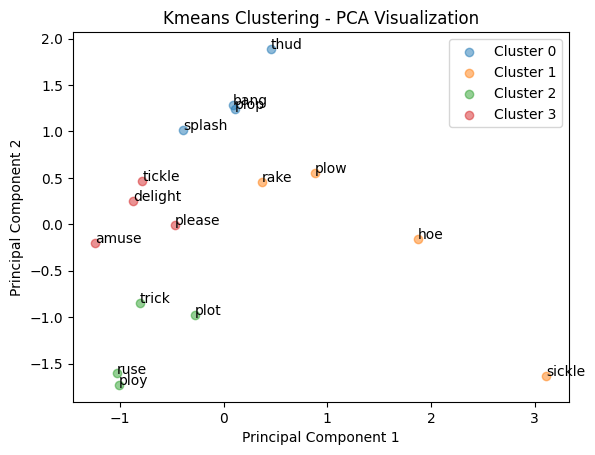

In [691]:
clusters, sil_score = kmeans_clustering(word_embeddings[0], connections_games[0], visualize=True, reduction='pca')